# GSA Prediction Project by Yanjia (Joy) Bai

***
## Table of Contents
* [1. Project description](#desc)
 * [1.1 Data](#data)
 * [1.2 Task](#task)
 * [1.3 Overview](#overview)
* [2. Exploratory data analysis](#eda)
* [3. Tests](#tests)
 * [3.1 ADF test for unit root](#adf)
 * [3.2 KPSS test for stationarity](#kpss)
 * [3.3 Johensen cointegration test](#coint)
* [4. Modelling](#model)
 * [4.1 First trial: VAR model](#var)
 * [4.2 ARIMA: a preperation for the later VARMAX](#arima)
 * [4.3 VARMAX model with grid search](#varmax)
* [5. Future work](#future)
* [Reference](#ref)

***

## 1. Project description<a class="anchor" id="desc"></a>

### 1.1 Data<a class="anchor" id="data"></a>

The file data.csv contains price data for two financial instruments, called X and Y. These are real market prices, sampled once every 10 seconds in the year 2013. The four columns are

- timestamp - the timestamp of this observation (milliseconds since 00:00:00 January 1, 1970)
- xprice - the price of instrument X
- yprice - the price of instrument Y
- returns - the returns of instrument Y

The returns column is defined to be *the price ten minutes from now, minus the current price*. It has been truncated to remove outliers. In the event that *there is no price ten minutes from now (because the market has closed, for example) then the latest price available is used*.

The data.csv has been splitted into train.csv and test.csv. 

### 1.2 Task<a class="anchor" id="task"></a>

The task is to build a model to predict the returns of asset Y using the price history of X and Y. The model will be judged on out-of-sample mean squared prediction error. 

### 1.3 Overview<a class="anchor" id="overview"></a>

I started from exploring the train data set. After plotting the prices of X and Y, I realized that the prices of these two financial instruments might have a high correlation. Moreover, the returns of Y, as given in the data set, seems to form a stationary time series. 

I proceeded by calculating the returns of X, using the same method for calculating the given returns of Y. Since the ADF test shows that both returns of X and Y form stationary time series and the Johansen cointegration test suggests that the two time series are correlated, I decided to use method designed for multivariate time series on the dataframe `['returns of Y', 'returns of X']`. 

I used the `VARMAX` method in package `statsmodels`, which allows estimation of VAR (Vector Autoregression), VMA (Vector Moving Average), and VARMA (Vector Autoregression Moving Average) models and is specified as follows:
$$ y_t = \nu + A_1 y_{t-1} + \cdots + A_p y_{p-1} + \epsilon_t+M_1\epsilon_{t-1}+\cdots+M_q\epsilon_{t-q}.$$

In the above, `p` is the number of autoregressive terms, and `q` is the number of moving average terms. To decide what `p`,`q` values to use in `VARMAX`, I fitted separately `returns of Y` and `returns of X` to `ARIMA` (Autoregressive Integrated Moving Average) model using `auto_arima` in package `pmdarima`, derived respectively two pairs of `(p,q)` values, and used these to fit the `VARMAX` model. In the end, I chose `(p,q)` values which gave a smaller MSE in the validation set. The model is stored in a pickle file to predict values for the test set.

In the final submitted solution.py, I actually used a `VAR` model, because the `auto_arima` and then `VARMAX` approach exceeded the time and/or memory limit of the virtual machine. Besides, the MSEs given by these two approaches are very similar. The solution.py in github repo was the old version where I tried the second approach.

My solution is written in the files solution.py, calculate_returns.py, and tests.py. The aim of this Jupyter notebook is to provide a more detailed explanation with test results and visualizations, which I could not include in my solution files because of the execution time limit in the virtual machine Codebase.

## 2. Exploratory data analysis<a class="anchor" id="eda"></a>

In [77]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd
from decimal import Decimal, getcontext
import matplotlib.dates as mdates
# Plots
# ==============================================================================
import matplotlib.pyplot as plt

plt.style.use('seaborn-deep')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [78]:
print('numpy==', np.__version__)
print('pandas==', pd.__version__)
print('scipy==', scipy.__version__)
print('statsmodels==', statsmodels.__version__)
print('project requirement, numpy==1.18.1, pandas==1.0.1, scipy==1.4.1, statsmodels==0.11.0')

numpy== 1.20.2
pandas== 1.2.5
scipy== 1.6.2
statsmodels== 0.13.2
project requirement, numpy==1.18.1, pandas==1.0.1, scipy==1.4.1, statsmodels==0.11.0


After converting the `timestamp` column in the given data set, we can see that the train set contains records from 2013-01-03 to 2013-09-30, while the test set contains records from 2013-10-01 to 2013-12-30. Together, they provide the price data for X and Y in the year 2013.

In [129]:
# read train and test data from csv files
#data = pd.read_csv('data.csv')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
#print('data shapes: data, train, test, ', data.shape, train.shape, test.shape)

# convert timestamp to datetime and add one column with just date
def add_dates(df, col_time):
    df['time_tmp'] = pd.to_datetime(df[col_time], unit='ms')
    df['date'] = df[col_time]
    df['date'] = pd.to_datetime(df['date'], unit='ms').dt.date

add_dates(train, 'timestamp')
add_dates(test, 'timestamp')
train.head()

,timestamp,xprice,yprice,returns,time_tmp,date
0,1357225500000,139.8375,169.2500,0.3125,2013-01-03 15:05:00,2013-01-03
1,1357225510000,139.8875,169.3000,0.2750,2013-01-03 15:05:10,2013-01-03
2,1357225520000,139.8625,169.3375,0.2500,2013-01-03 15:05:20,2013-01-03
3,1357225530000,139.8375,169.3625,0.2375,2013-01-03 15:05:30,2013-01-03
4,1357225540000,139.8375,169.3625,0.3250,2013-01-03 15:05:40,2013-01-03


In the following, I replicate the method to calculate the given `returns` column in the data sets, and calculate the returns of X. Note that I have checked that my method indeed gives the same results for Y by checking that `yreturns` and `returns` are the same. I wrote the same procedures for the train and test sets, which can of course be combined by writing a function. 

In [136]:
# calculate xreturns, yreturns is also calculated just to check against the original returns
if len(set(train.groupby(['date']).size())) == 1:
    n_samples_per_day = train.groupby(['date']).size()[0]
else:
    raise ValueError('Different numbers of stock price samples per day!')

getcontext().prec = 6 # set floating point precision
xreturns = [0.0]*train.shape[0]
yreturns = [0.0]*train.shape[0]
for i in range(train.shape[0]):
    day, loc = divmod(i, n_samples_per_day) # day = number of days since 0th day, loc = what time in one day
    if loc < 1349: # not in last 10 minutes of a day
        xreturns[i] = Decimal(train['xprice'][i+60]) - Decimal(train['xprice'][i]) # return = 10-minute-later price - current price
        yreturns[i] = Decimal(train['yprice'][i+60]) - Decimal(train['yprice'][i])
    else: # in last 10 minutes of a day
        xreturns[i] = Decimal(train['xprice'][n_samples_per_day*(day+1)-1]) - Decimal(train['xprice'][i])
        yreturns[i] = Decimal(train['yprice'][n_samples_per_day*(day+1)-1]) - Decimal(train['yprice'][i])
train['yreturns'] = [float(i) for i in yreturns]
train['xreturns'] = [float(i) for i in xreturns]
# truncate outliers
train.loc[train['yreturns'] > 0.875, 'yreturns'] = 0.875
train.loc[train['yreturns'] < -0.875, 'yreturns'] = -0.875
train.loc[train['xreturns'] > 0.875, 'xreturns'] = 0.875
train.loc[train['xreturns'] < -0.875, 'xreturns'] = -0.875

print('The number of differences between the given returns and the calculated yreturns is ', sum(train['yreturns']!=train['returns']))

train.describe()

The number of differences between the given returns and the calculated yreturns is  0


,timestamp,xprice,yprice,returns,yreturns,xreturns
count,2.594400e+05,259440.000000,259440.000000,259440.000000,259440.000000,259440.000000
mean,1.368824e+12,132.010113,156.344201,-0.001277,-0.001277,-0.004049
std,6.740635e+09,2.504086,5.263951,0.179003,0.179003,0.140346
min,1.357226e+12,127.537500,147.175000,-0.875000,-0.875000,-0.875000
25%,1.363079e+12,130.350000,151.525000,-0.087500,-0.087500,-0.075000
50%,1.368677e+12,131.650000,156.550000,0.000000,0.000000,0.000000
75%,1.374707e+12,132.987500,158.825000,0.087500,0.087500,0.075000
max,1.380564e+12,141.412500,172.000000,0.875000,0.875000,0.875000


In [130]:
test['date'] = test['timestamp']
test['date'] = pd.to_datetime(test['date'], unit='ms').dt.date

# calculate xreturns, yreturns is also calculated just to check against the original returns
if len(set(test.groupby(['date']).size())) == 1:
    n_samples_per_day = test.groupby(['date']).size()[0]
else:
    raise ValueError('Different numbers of stock price samples per day!')

getcontext().prec = 6 # set floating point precision
xreturns = [0.0]*test.shape[0]
for i in range(test.shape[0]):
    day, loc = divmod(i, n_samples_per_day) # day = number of days since 0th day, loc = what time in one day
    if loc < 1349: # not in last 10 minutes of a day
        xreturns[i] = Decimal(test['xprice'][i+60]) - Decimal(test['xprice'][i]) # return = 10-minute-later price - current price
    else: # in last 10 minutes of a day
        xreturns[i] = Decimal(test['xprice'][n_samples_per_day*(day+1)-1]) - Decimal(test['xprice'][i])
test['xreturns'] = [float(i) for i in xreturns]
# truncate outliers
test.loc[test['xreturns'] > 0.875, 'xreturns'] = 0.875
test.loc[test['xreturns'] < -0.875, 'xreturns'] = -0.875

test.describe()

,timestamp,xprice,yprice,returns,xreturns
count,8.319000e+04,83190.000000,83190.000000,83190.000000,83190.000000
mean,1.384244e+12,133.638154,164.579835,-0.003150,-0.002121
std,2.220400e+09,0.889931,1.787169,0.135179,0.103264
min,1.380636e+12,131.262500,160.437500,-0.875000,-0.875000
25%,1.382375e+12,133.037500,163.337500,-0.062500,-0.050000
50%,1.384189e+12,133.612500,164.487500,0.000000,0.000000
75%,1.386259e+12,134.262500,165.800000,0.062500,0.050000
max,1.388430e+12,135.862500,168.700000,0.850000,0.875000


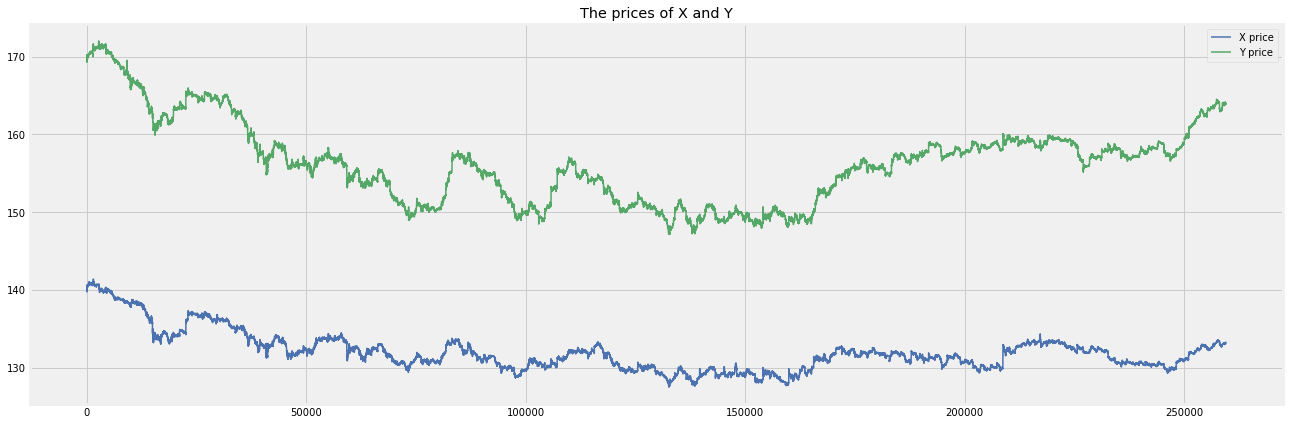

In [110]:
train['xprice'].plot(label = 'X price', figsize = (20,7))
train['yprice'].plot(label = 'Y price')
plt.title('The prices of X and Y')
plt.legend()

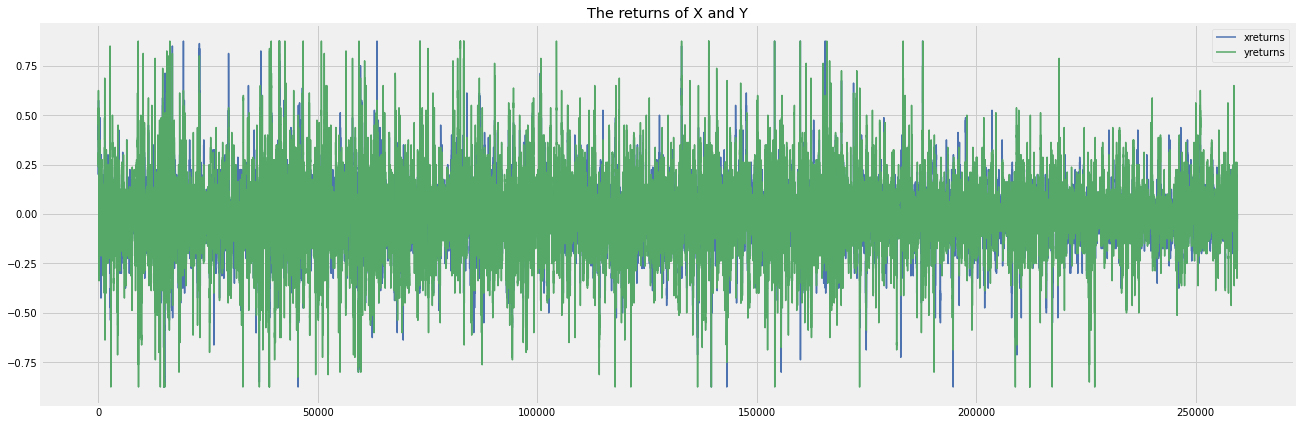

In [111]:
train['xreturns'].plot(figsize = (20,7))
train['yreturns'].plot()
plt.title('The returns of X and Y')
plt.legend()
plt.show()

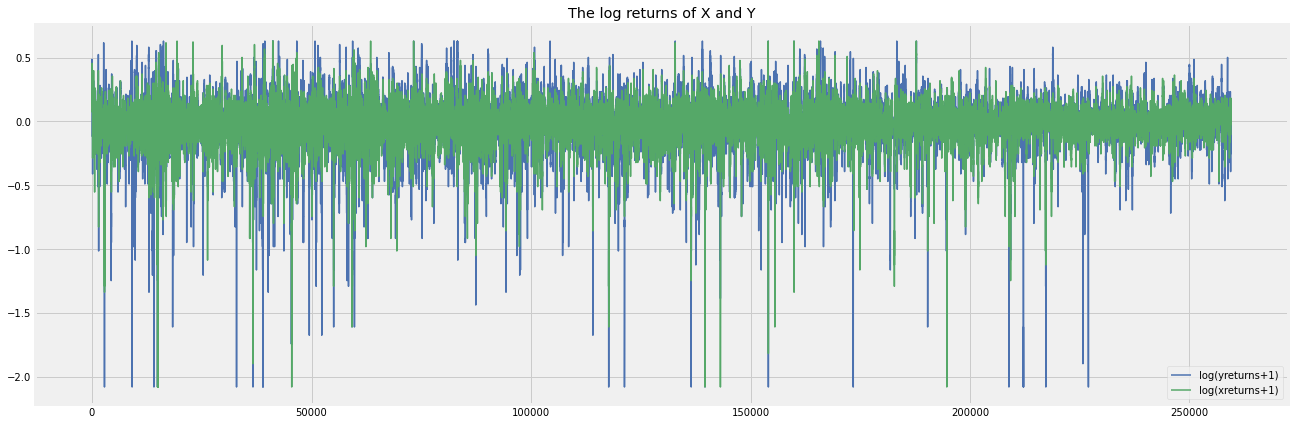

In [109]:
log_y_returns = np.log(train['yreturns']+1)
log_x_returns = np.log(train['xreturns']+1)
plt.title('The log returns of X and Y')
log_y_returns.plot(label='log(yreturns+1)', figsize=(20, 7))
log_x_returns.plot(label='log(xreturns+1)')
plt.legend()

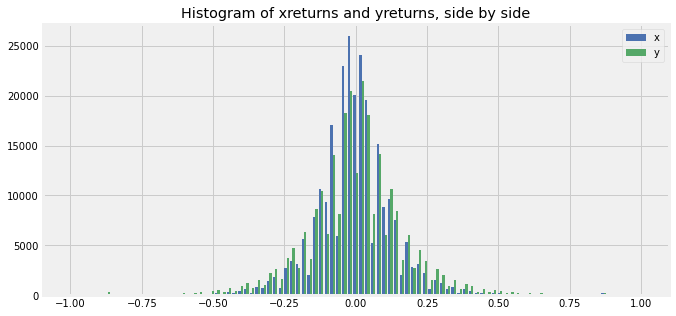

In [107]:
bins = np.linspace(-1, 1, 100)
plt.figure(figsize=(10,5))
plt.hist([train['xreturns'], train['yreturns']], bins, label=['x', 'y'])
plt.legend(loc='upper right')
plt.title('Histogram of xreturns and yreturns, side by side')
plt.show()

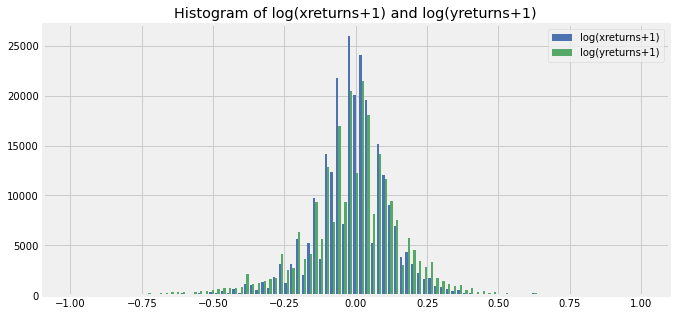

In [108]:
plt.style.use('seaborn-deep')

bins = np.linspace(-1, 1, 100)
plt.figure(figsize=(10,5))
plt.hist([log_x_returns, log_y_returns], bins, label=['log(xreturns+1)', 'log(yreturns+1)'])
plt.legend(loc='upper right')
plt.title('Histogram of log(xreturns+1) and log(yreturns+1)')
plt.show()

In [112]:
train.corr()

,timestamp,xprice,yprice,returns,yreturns,xreturns
timestamp,1.000000,-0.518359,-0.188121,0.023849,0.023849,0.010282
xprice,-0.518359,1.000000,0.874105,-0.036225,-0.036225,-0.047536
yprice,-0.188121,0.874105,1.000000,-0.034677,-0.034677,-0.041097
returns,0.023849,-0.036225,-0.034677,1.000000,1.000000,0.693957
yreturns,0.023849,-0.036225,-0.034677,1.000000,1.000000,0.693957
xreturns,0.010282,-0.047536,-0.041097,0.693957,0.693957,1.000000


## 3. Tests<a class="anchor" id="test"></a>

The above plots suggest that the returns of X and Y seem to be stationary time series. I verify this by firstly an ADF (Augmented Dickey–Fuller) test for unit root and then a KPSS (Kwiatkowski–Phillips–Schmidt–Shin) test for stationarity. I also try a Johansen cointegration test on `['returns', 'xreturns']` as a multivariate time series.

### 3.1 ADF Test for unit root<a class="anchor" id="adf"></a>

If p-value is small, we can reject the null hypothesis that the time series has a unit root, which is the case in our data.

In [113]:
#Test for stationarity
def test_adf(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(n_samples_per_day).mean()
    rolstd = timeseries.rolling(n_samples_per_day).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

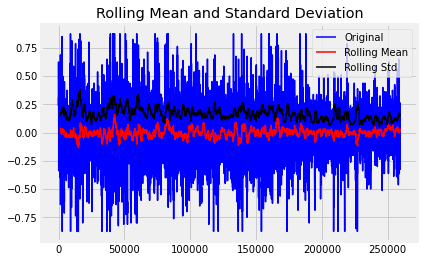

Results of dickey fuller test
Test Statistics                   -41.974192
p-value                             0.000000
No. of lags used                   86.000000
Number of observations used    259353.000000
critical value (1%)                -3.430375
critical value (5%)                -2.861551
critical value (10%)               -2.566776
dtype: float64


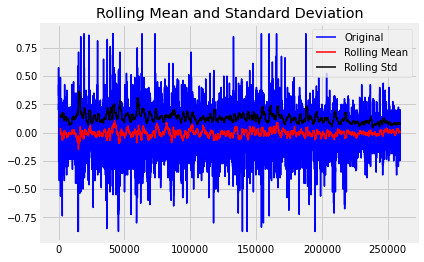

Results of dickey fuller test
Test Statistics                   -41.901527
p-value                             0.000000
No. of lags used                   86.000000
Number of observations used    259353.000000
critical value (1%)                -3.430375
critical value (5%)                -2.861551
critical value (10%)               -2.566776
dtype: float64


In [114]:
test_adf(train['returns'])
test_adf(train['xreturns'])

### 3.2 KPSS test for stationarity<a class="anchor" id="kpss"></a>

The following KPSS tests on `returns` and `xreturns` suggest that we can't reject null hypothesis and that the time series are not stationary. This contradicts with our result from the ADF test. However, the p-values here are not very large (0.10 for both series). I read [this post](https://stats.stackexchange.com/questions/30569/what-is-the-difference-between-a-stationary-test-and-a-unit-root-test/235916#235916) and decide to still assume our time series are stationary.

In [115]:
from statsmodels.tsa.stattools import kpss
def test_kpss(timeseries):
    kpsst = kpss(timeseries)
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(kpsst[0:3],index=['Test Statistics','p-value','No. of lags used'])
    for key,values in kpsst[3].items():
        output['critical value (%s)'%key] =  values
    print(output)
test_kpss(train['returns'])
test_kpss(train['xreturns'])

Test Statistics            0.291116
p-value                    0.100000
No. of lags used         275.000000
critical value (10%)       0.347000
critical value (5%)        0.463000
critical value (2.5%)      0.574000
critical value (1%)        0.739000
dtype: float64
Test Statistics            0.093134
p-value                    0.100000
No. of lags used         276.000000
critical value (10%)       0.347000
critical value (5%)        0.463000
critical value (2.5%)      0.574000
critical value (1%)        0.739000
dtype: float64


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning
/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:2023: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warn_msg.format(direction="greater"), InterpolationWarning


### 3.3 Johansen cointegration test<a class="anchor" id="coint"></a>

This test shows that it makes sense to treat `['returns','xreturns']` as a multivariate time series. This is why I only use vector models in the Modelling section.

In [116]:
from statsmodels.tsa.vector_ar.vecm import coint_johansen

def cointegration_test(df): 
    res = coint_johansen(df,-1,5)
    d = {'0.90':0, '0.95':1, '0.99':2}
    traces = res.lr1
    cvts = res.cvt[:, d[str(1-0.05)]]
    def adjust(val, length= 6): 
        return str(val).ljust(length)
    print('Column Name   >  Test Stat > C(95%)    =>   Signif  \n', '--'*20)
    for col, trace, cvt in zip(df.columns, traces, cvts):
        print(adjust(col), '> ', adjust(round(trace,2), 9), ">", adjust(cvt, 8), ' =>  ' , trace > cvt)
cointegration_test(train[['xreturns', 'returns']])

Column Name   >  Test Stat > C(95%)    =>   Signif  
 ----------------------------------------
xreturns >  5240.24   > 12.3212   =>   True
returns >  2220.91   > 4.1296    =>   True


## 4. Modelling<a class="anchor" id="model"></a>


### 4.1 First trial: VAR model<a class="anchor" id="var"></a>

In this section, I also tried the VAR model. I didn't include this in my solution because I decided to use VARMAX in the end.

In [124]:
model_var = VAR(train[['returns', 'xreturns']])

In [125]:
model_var.select_order(10).summary()

,AIC,BIC,FPE,HQIC
0,-8.025,-8.025,0.0003271,-8.025
1,-14.24,-14.24,6.526e-07,-14.24
2,-14.26,-14.26,6.420e-07,-14.26
3,-14.26,-14.26,6.408e-07,-14.26
4,-14.26,-14.26,6.403e-07,-14.26
5,-14.26,-14.26,6.401e-07,-14.26
6,-14.26,-14.26,6.399e-07,-14.26
7,-14.26,-14.26*,6.397e-07,-14.26
8,-14.26,-14.26,6.396e-07,-14.26
9,-14.26,-14.26,6.396e-07,-14.26


In [126]:
max_lag = 8
results_var = model_var.fit(maxlags=max_lag, ic='aic')
results_var.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Sun, 22, May, 2022
Time:                     21:27:07
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -14.2610
Nobs:                     259432.    HQIC:                  -14.2620
Log likelihood:       1.11385e+06    FPE:                6.39639e-07
AIC:                     -14.2624    Det(Omega_mle):     6.39555e-07
--------------------------------------------------------------------
Results for equation returns
                 coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------
const               0.000017         0.000064            0.265           0.791
L1.returns          0.937267         0.002159          434.050           0.000
L1.xreturns         0.148692         0.002641           56.302    

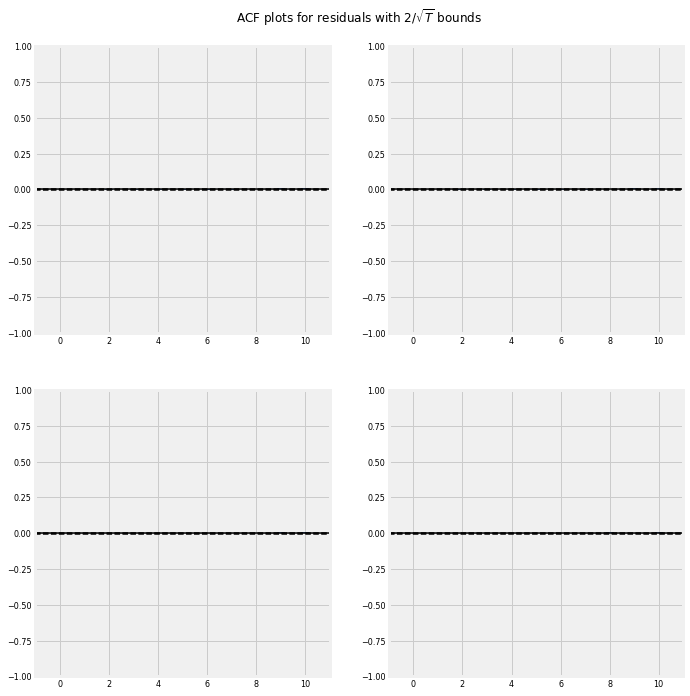

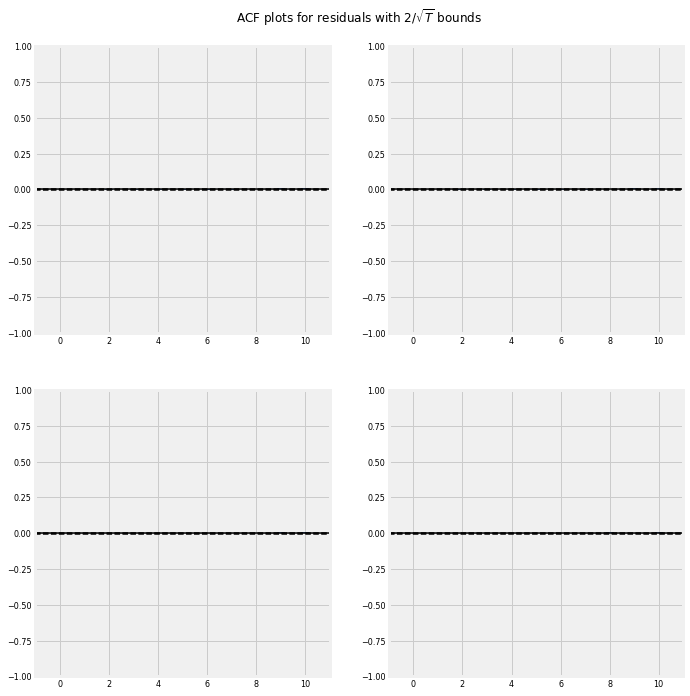

In [127]:
results_var.plot_acorr()

In [155]:
lag_order = results_var.k_ar
pred_var_arr = results_var.forecast(train[['returns', 'xreturns']][-lag_order:].values, test.shape[0])
n = len(pred_var_arr)
pred_var = []
for i in range(n):
    pred_var.append(pred_var_arr[i][0])
mse_var = ((pred_var - test['returns'])**2).mean()
print('The mean squared error of VAR model with lag ', lag_order, 'is: ', mse_var)

The mean squared error of VAR model with lag  8 is:  0.018276564909981474


### 4.2 ARIMA: a preperation for the later VARMAX<a class="anchor" id="arima"></a>

In this section, I use `auto_arima` to determine separately the best `(p,q)` values for `returns` and `xreturns`. These will later be used as parameters in the VARMAX model.

In [14]:
pq = []
for name, column in train[[ 'returns', 'xreturns']].iteritems():
    print(f'Searching order of p and q for : {name}')
    stepwise_model = auto_arima(train[name],start_p=1, start_q=1,max_p=7, max_q=7, seasonal=False,
        trace=True,error_action='ignore',suppress_warnings=True, stepwise=True,maxiter=1000)
    parameter = stepwise_model.get_params().get('order')
    print(f'optimal order for:{name} is: {parameter} \n\n')
    pq.append(stepwise_model.get_params().get('order'))

Searching order of p and q for : returns
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1030618.420, Time=53.55 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1030646.719, Time=24.38 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1030646.851, Time=27.57 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1030646.856, Time=43.11 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1030648.719, Time=8.83 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 157.506 seconds
optimal order for:returns is: (0, 1, 0) 


Searching order of p and q for : xreturns
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1140867.579, Time=19.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-282420.193, Time=7.89 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1140685.470, Time=14.34 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-572922.649, Time=25.41 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-1140868.663, Time=21.45 sec
 AR

### 4.3 VARMAX model with grid search<a class="anchor" id="varmax"></a>

I use the `(p,q)` values derived from the above section to perform a grid search and fit the VARMAX model. The chosen parameters are those which give the smallest MSE. Note that here further split the train set into a train set and a validation set for the grid search. 

In [156]:
df = train[['returns', 'xreturns']] # the given train set, to be splitted into train_df and val_df
train_size = int(df.shape[0] * 0.8)
train_df = df[0:train_size] # train set 
val_df = df[train_size:].reset_index(drop=True) # validation set

In [157]:
data_results_moni = pd.DataFrame(columns=['p', 'q','MSE returns','MSE xreturns'])
models = []
print('Grid Search Started')
start = time.time()
for i in pq:
    if i[0]== 0 and i[2] ==0:
        pass
    else:
        print(f' Running for {i}')
        model = VARMAX(train_df, order=(i[0],i[2])).fit(disp=False)
        models.append(model)
        result = model.forecast(steps = val_df.shape[0]).reset_index(drop=True)
        returns_mse = ((result['returns'] - val_df['returns'])**2).mean()
        xreturns_mse = ((result['xreturns'] - val_df['xreturns'])**2).mean()
        data_results_moni = data_results_moni.append({'p': i[0], 'q': i[2], 'MSE returns':returns_mse,'MSE xreturns':xreturns_mse}, ignore_index=True)
end = time.time()
print(f' Total time taken to complete grid search in seconds: {(end - start)}')
data_results_moni

Grid Search Started
 Running for (2, 0, 1)


/opt/anaconda3/envs/py37/lib/python3.7/site-packages/statsmodels/tsa/statespace/varmax.py:163: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  EstimationWarning)


 Running for (7, 0, 0)
 Total time taken to complete grid search in seconds: 462.3502628803253


,p,q,MSE returns,MSE xreturns
0,2.0,1.0,0.019512,0.009899
1,7.0,0.0,0.019511,0.009900


As shown in the above table, the MSE results are quite similar for `(p,q)=(2,1)` and `(p,q)=(7,0)`. As suggested by the [auto_arima documentation](https://alkaline-ml.com/pmdarima/tips_and_tricks.html#pipelining), higher p,q values could be just overfitting anyways. I print the summary of the model `VARMA(2,1)` below.

In [7]:
model.summary()

Dep. Variable:,"['returns', 'xreturns']",No. Observations:,259440
Model:,"VARMA(2,1)",Log Likelihood,1113368.097
,+ intercept,AIC,-2226702.194
Date:,"Sun, 22 May 2022",BIC,-2226524.267
Time:,11:15:55,HQIC,-2226650.411
Sample:,0,,
,- 259440,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.00, 0.00",Jarque-Bera (JB):,"26838410.66, 23306861.65"
Prob(Q):,"0.95, 0.98",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"0.53, 0.56",Skew:,"-0.06, -0.76"


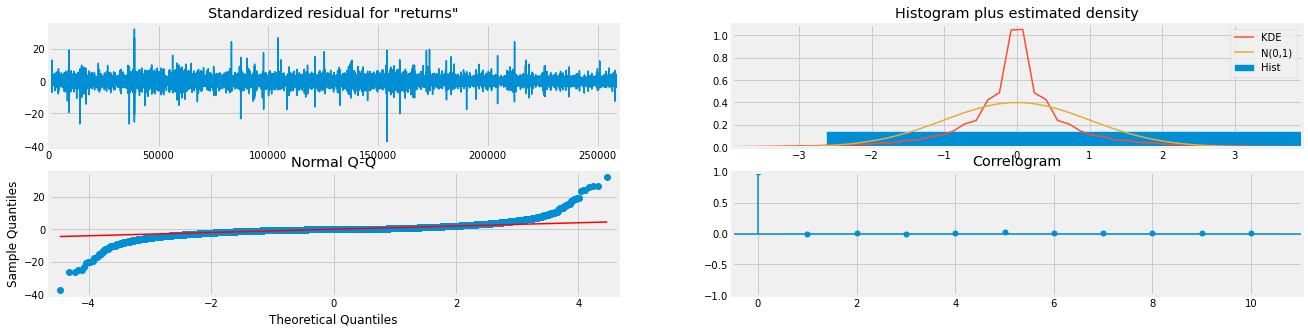

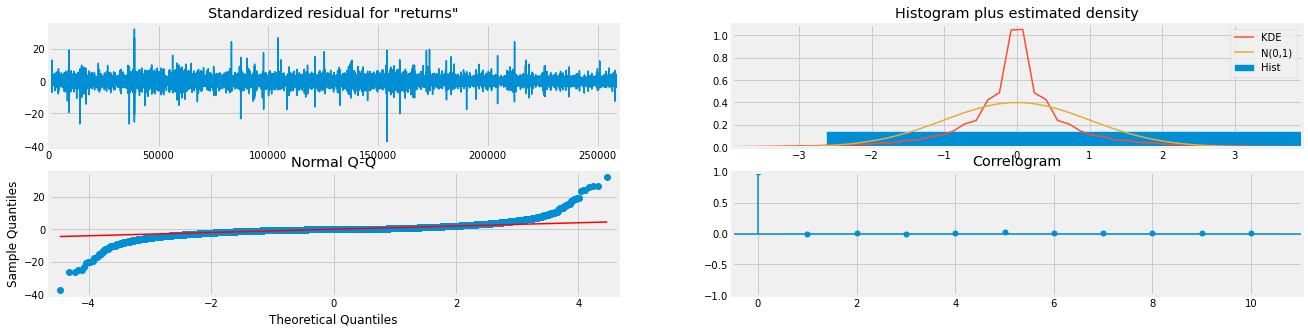

In [22]:
model.plot_diagnostics(figsize=(20,5))

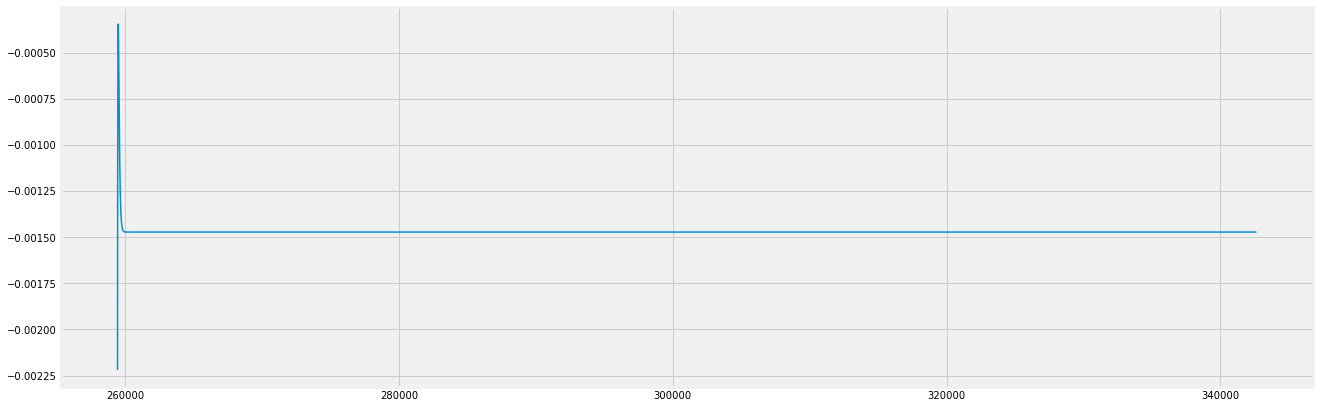

In [37]:
result['returns'].plot(figsize=(20, 7))

If you are interested, below is the results for `VARMA(7,0)`. 

In [8]:
import time
start = time.time()
model2 = VARMAX(train[[ 'returns', 'xreturns']], order=(7,0)).fit()
result2 = model.forecast(steps = test.shape[0])
print(time.time()-start, result2)

495.5118980407715          returns  xreturns
259440 -0.002220  0.001743
259441 -0.001816  0.001487
259442 -0.001764  0.001393
259443 -0.001683  0.001284
259444 -0.001609  0.001179
...          ...       ...
342625 -0.001472 -0.004203
342626 -0.001472 -0.004203
342627 -0.001472 -0.004203
342628 -0.001472 -0.004203
342629 -0.001472 -0.004203

[83190 rows x 2 columns]


<AxesSubplot:>

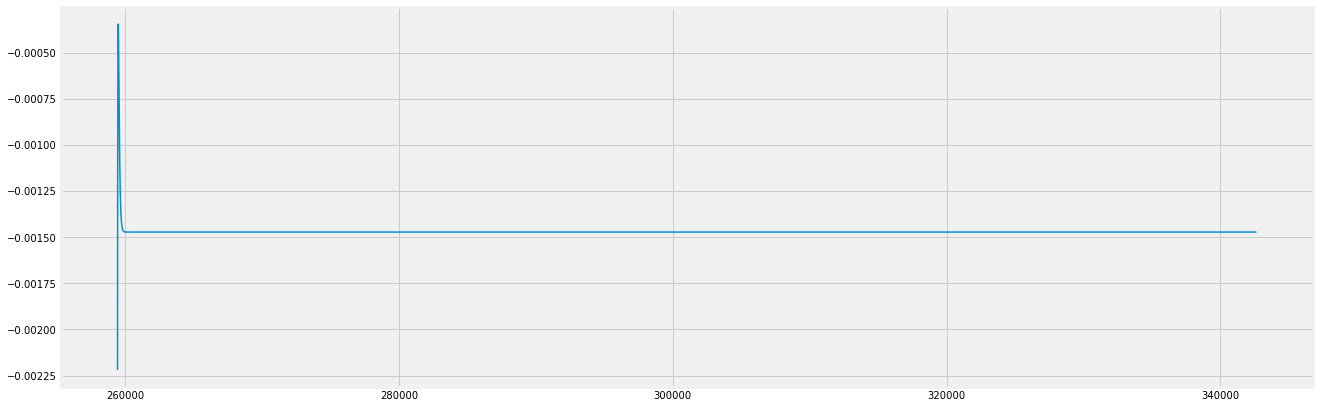

In [9]:
result2['returns'].plot(figsize=(20, 7))

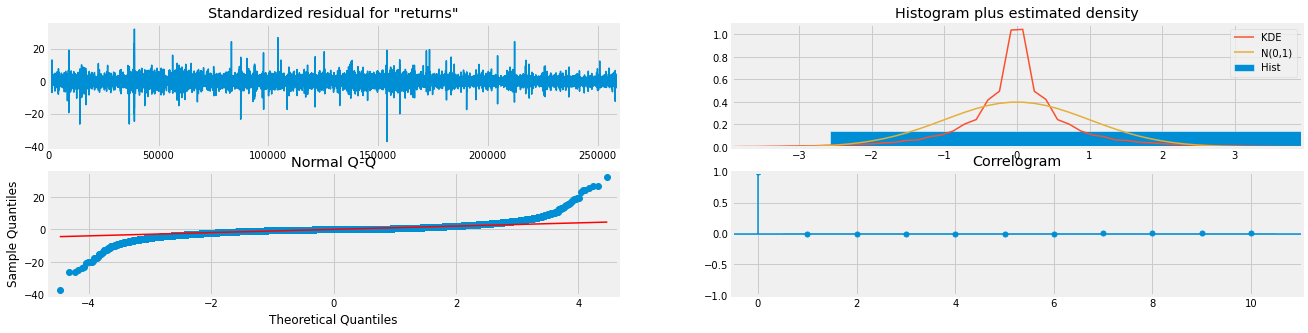

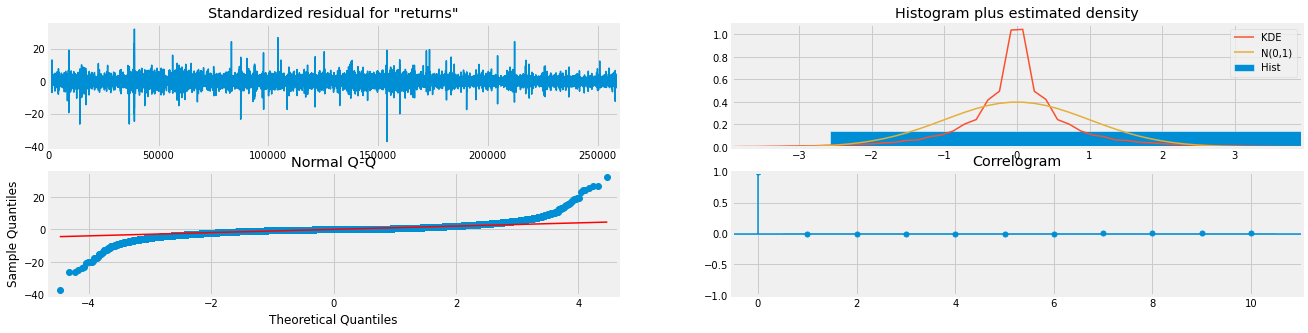

In [23]:
model2.plot_diagnostics(figsize=(20,5))

In [11]:
model2.summary()

Dep. Variable:,"['returns', 'xreturns']",No. Observations:,259440
Model:,VAR(7),Log Likelihood,1113844.421
,+ intercept,AIC,-2227622.841
Date:,"Sun, 22 May 2022",BIC,-2227277.454
Time:,11:28:23,HQIC,-2227522.321
Sample:,0,,
,- 259440,,
Covariance Type:,opg,,
Ljung-Box (L1) (Q):,"0.01, 0.00",Jarque-Bera (JB):,"26368617.43, 23233466.15"
Prob(Q):,"0.94, 0.98",Prob(JB):,"0.00, 0.00"
Heteroskedasticity (H):,"0.53, 0.56",Skew:,"-0.06, -0.76"


## 5. Future work<a class="anchor" id="future"></a>

As you can see from the above plots of the predicted values, by using VARMA model the predicted values will converge to a constant as time goes by. Although the MSE between the predicted values and the true ones is quite small, the prediction does not look very exciting. The key problem is that I have only fitted the model once and never revised the parameters using new (predicted) data.

If I have more time, I would like to try to improve the current results by the following two methods:
1. There seems to be a library which allows recursive multi-step forecasting (see reference no. 3). I didn't use that in this project, because the package versions in `requirements.txt` have conflicts with the required environment of `skforecast`.
2. There are some bleeding-edge methods such as neural networks. See reference no.8 for a very nice documentation in Tensorflow.

## References<a class="anchor" id="ref"></a>

1. Stock market forecasting using ARIMA
https://www.kdnuggets.com/2020/01/stock-market-forecasting-time-series-analysis.html
 
2. Time series in finance ("pair trading")
 https://cs.nyu.edu/~shasha/papers/jagtalk.html
 
3. Skforecast
 https://www.cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html
 
4. Intuition of unit root
 https://stats.stackexchange.com/questions/29121/intuitive-explanation-of-unit-root
 
5. Unit-root test vs. stationary test
 https://stats.stackexchange.com/questions/30569/what-is-the-difference-between-a-stationary-test-and-a-unit-root-test/235916#235916
 
6. Document and tips for pmdarima.auto_arima
 https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html https://alkaline-ml.com/pmdarima/tips_and_tricks.html
 
7. Examples of using auto-arima model and then VARMA
 code: https://github.com/Apress/hands-on-time-series-analylsis-python/blob/master/Chapter%204/7.%20VARMA%20with%20Auto%20Arima.ipynb
 explanation: https://analyticsindiamag.com/a-guide-to-varma-with-auto-arima-in-time-series-modelling/
 
8. Tensorflow documentation for time series analysis
https://www.tensorflow.org/tutorials/structured_data/time_series